In [1]:
import pandas as pd  
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sb

import requests
import json
from bs4 import BeautifulSoup
from requests.auth import HTTPBasicAuth #authentication code
from getpass import getpass

import time

## Kaagle Dataset - The Academy awards (1927-2015)

In [2]:
#import oscars dataset file
#1927-2015

oscars = pd.read_csv('database.csv', low_memory=False)
oscars.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1927/1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1927/1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1927/1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1927/1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1927/1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson


This database itself doesn't tell a lot 

In [3]:
oscars['Award'].unique()

array(['Actor', 'Actress', 'Art Direction', 'Cinematography',
       'Directing (Comedy Picture)', 'Directing (Dramatic Picture)',
       'Engineering Effects', 'Outstanding Picture',
       'Unique and Artistic Picture', 'Writing (Adaptation)',
       'Writing (Original Story)', 'Writing (Title Writing)',
       'Special Award', 'Directing', 'Writing', 'Outstanding Production',
       'Sound Recording', 'Short Subject (Cartoon)',
       'Short Subject (Comedy)', 'Short Subject (Novelty)',
       'Assistant Director', 'Film Editing', 'Music (Scoring)',
       'Music (Song)', 'Dance Direction', 'Writing (Screenplay)',
       'Actor in a Supporting Role', 'Actress in a Supporting Role',
       'Short Subject (Color)', 'Short Subject (One Reel)',
       'Short Subject (Two Reel)', 'Irving G. Thalberg Memorial Award',
       'Music (Original Score)', 'Cinematography (Black and White)',
       'Cinematography (Color)', 'Special Effects',
       'Art Direction (Black and White)', 'Art Direct

In [4]:
#For now I'd like to analyse the Best Picture award aka 'Outstanding Picture'
#from 1962, before that it was called 'Best Motion Picture'
#i've decided to use from 1962 - making it a threshold - previous to that very few movie reviews
oscars = oscars[(oscars['Award']=='Best Picture')]
oscars

,Year,Ceremony,Award,Winner,Name,Film
3924,1962,35,Best Picture,1.0,Lawrence of Arabia,"Sam Spiegel, Producer"
3925,1962,35,Best Picture,NaN,The Longest Day,"Darryl F. Zanuck, Producer"
3926,1962,35,Best Picture,NaN,Meredith Willson's The Music Man,"Morton Da Costa, Producer"
3927,1962,35,Best Picture,NaN,Mutiny on the Bounty,"Aaron Rosenberg, Producer"
3928,1962,35,Best Picture,NaN,To Kill a Mockingbird,"Alan J. Pakula, Producer"
...,...,...,...,...,...,...
9916,2015,88,Best Picture,NaN,Mad Max: Fury Road,"Doug Mitchell and George Miller, Producers"
9917,2015,88,Best Picture,NaN,The Martian,"Simon Kinberg, Ridley Scott, Michael Schaefer ..."
9918,2015,88,Best Picture,NaN,The Revenant,"Arnon Milchan, Steve Golin, Alejandro G. Iñárr..."
9919,2015,88,Best Picture,NaN,Room,"Ed Guiney, Producer"


In [5]:
oscars = oscars.rename({'Name': 'title'}, axis=1)
oscars.head()

,Year,Ceremony,Award,Winner,title,Film
3924,1962,35,Best Picture,1.0,Lawrence of Arabia,"Sam Spiegel, Producer"
3925,1962,35,Best Picture,NaN,The Longest Day,"Darryl F. Zanuck, Producer"
3926,1962,35,Best Picture,NaN,Meredith Willson's The Music Man,"Morton Da Costa, Producer"
3927,1962,35,Best Picture,NaN,Mutiny on the Bounty,"Aaron Rosenberg, Producer"
3928,1962,35,Best Picture,NaN,To Kill a Mockingbird,"Alan J. Pakula, Producer"


In [6]:
oscars['title_year']= oscars['title'].str.strip() + " " + oscars['Year']
oscars.head()

,Year,Ceremony,Award,Winner,title,Film,title_year
3924,1962,35,Best Picture,1.0,Lawrence of Arabia,"Sam Spiegel, Producer",Lawrence of Arabia 1962
3925,1962,35,Best Picture,NaN,The Longest Day,"Darryl F. Zanuck, Producer",The Longest Day 1962
3926,1962,35,Best Picture,NaN,Meredith Willson's The Music Man,"Morton Da Costa, Producer",Meredith Willson's The Music Man 1962
3927,1962,35,Best Picture,NaN,Mutiny on the Bounty,"Aaron Rosenberg, Producer",Mutiny on the Bounty 1962
3928,1962,35,Best Picture,NaN,To Kill a Mockingbird,"Alan J. Pakula, Producer",To Kill a Mockingbird 1962


In [7]:
#get names to search API

list_tiles = list(oscars['title'])
print(list_tiles)

['Lawrence of Arabia ', 'The Longest Day ', "Meredith Willson's The Music Man ", 'Mutiny on the Bounty ', 'To Kill a Mockingbird ', 'America America ', 'Cleopatra ', 'How the West Was Won ', 'Lilies of the Field ', 'Tom Jones ', 'Becket ', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb ', 'Mary Poppins ', 'My Fair Lady ', 'Zorba the Greek ', 'Darling ', 'Doctor Zhivago ', 'Ship of Fools ', 'The Sound of Music ', 'A Thousand Clowns ', 'Alfie ', 'A Man for All Seasons ', 'The Russians Are Coming The Russians Are Coming ', 'The Sand Pebbles ', "Who's Afraid of Virginia Woolf? ", 'Bonnie and Clyde ', 'Doctor Dolittle ', 'The Graduate ', "Guess Who's Coming to Dinner ", 'In the Heat of the Night ', 'Funny Girl ', 'The Lion in Winter ', 'Oliver! ', 'Rachel, Rachel ', 'Romeo and Juliet ', 'Anne of the Thousand Days ', 'Butch Cassidy and the Sundance Kid ', 'Hello, Dolly! ', 'Midnight Cowboy ', 'Z ', 'Airport ', 'Five Easy Pieces ', 'Love Story ', 'MA*S*H ', 'Patton ', '

In [8]:
list_titles2 =[]
for element in list_tiles:
    list_titles2.append(element.strip())
print(list_titles2)

['Lawrence of Arabia', 'The Longest Day', "Meredith Willson's The Music Man", 'Mutiny on the Bounty', 'To Kill a Mockingbird', 'America America', 'Cleopatra', 'How the West Was Won', 'Lilies of the Field', 'Tom Jones', 'Becket', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb', 'Mary Poppins', 'My Fair Lady', 'Zorba the Greek', 'Darling', 'Doctor Zhivago', 'Ship of Fools', 'The Sound of Music', 'A Thousand Clowns', 'Alfie', 'A Man for All Seasons', 'The Russians Are Coming The Russians Are Coming', 'The Sand Pebbles', "Who's Afraid of Virginia Woolf?", 'Bonnie and Clyde', 'Doctor Dolittle', 'The Graduate', "Guess Who's Coming to Dinner", 'In the Heat of the Night', 'Funny Girl', 'The Lion in Winter', 'Oliver!', 'Rachel, Rachel', 'Romeo and Juliet', 'Anne of the Thousand Days', 'Butch Cassidy and the Sundance Kid', 'Hello, Dolly!', 'Midnight Cowboy', 'Z', 'Airport', 'Five Easy Pieces', 'Love Story', 'MA*S*H', 'Patton', 'A Clockwork Orange', 'Fiddler on the Roof', '

In [9]:
print(len(list_titles2))

298


In [10]:
newlist =[]
for element in list_titles2:
    newlist.append(element.split(" "))
print(newlist)

[['Lawrence', 'of', 'Arabia'], ['The', 'Longest', 'Day'], ['Meredith', "Willson's", 'The', 'Music', 'Man'], ['Mutiny', 'on', 'the', 'Bounty'], ['To', 'Kill', 'a', 'Mockingbird'], ['America', 'America'], ['Cleopatra'], ['How', 'the', 'West', 'Was', 'Won'], ['Lilies', 'of', 'the', 'Field'], ['Tom', 'Jones'], ['Becket'], ['Dr.', 'Strangelove', 'or:', 'How', 'I', 'Learned', 'to', 'Stop', 'Worrying', 'and', 'Love', 'the', 'Bomb'], ['Mary', 'Poppins'], ['My', 'Fair', 'Lady'], ['Zorba', 'the', 'Greek'], ['Darling'], ['Doctor', 'Zhivago'], ['Ship', 'of', 'Fools'], ['The', 'Sound', 'of', 'Music'], ['A', 'Thousand', 'Clowns'], ['Alfie'], ['A', 'Man', 'for', 'All', 'Seasons'], ['The', 'Russians', 'Are', 'Coming', 'The', 'Russians', 'Are', 'Coming'], ['The', 'Sand', 'Pebbles'], ["Who's", 'Afraid', 'of', 'Virginia', 'Woolf?'], ['Bonnie', 'and', 'Clyde'], ['Doctor', 'Dolittle'], ['The', 'Graduate'], ['Guess', "Who's", 'Coming', 'to', 'Dinner'], ['In', 'the', 'Heat', 'of', 'the', 'Night'], ['Funny', 

### The Movie Data Base

In [11]:
#play aroung with list above for API url
newlist2 =[]
for element in newlist:
    newlist2.append("+".join(element))
print(newlist2)

['Lawrence+of+Arabia', 'The+Longest+Day', "Meredith+Willson's+The+Music+Man", 'Mutiny+on+the+Bounty', 'To+Kill+a+Mockingbird', 'America+America', 'Cleopatra', 'How+the+West+Was+Won', 'Lilies+of+the+Field', 'Tom+Jones', 'Becket', 'Dr.+Strangelove+or:+How+I+Learned+to+Stop+Worrying+and+Love+the+Bomb', 'Mary+Poppins', 'My+Fair+Lady', 'Zorba+the+Greek', 'Darling', 'Doctor+Zhivago', 'Ship+of+Fools', 'The+Sound+of+Music', 'A+Thousand+Clowns', 'Alfie', 'A+Man+for+All+Seasons', 'The+Russians+Are+Coming+The+Russians+Are+Coming', 'The+Sand+Pebbles', "Who's+Afraid+of+Virginia+Woolf?", 'Bonnie+and+Clyde', 'Doctor+Dolittle', 'The+Graduate', "Guess+Who's+Coming+to+Dinner", 'In+the+Heat+of+the+Night', 'Funny+Girl', 'The+Lion+in+Winter', 'Oliver!', 'Rachel,+Rachel', 'Romeo+and+Juliet', 'Anne+of+the+Thousand+Days', 'Butch+Cassidy+and+the+Sundance+Kid', 'Hello,+Dolly!', 'Midnight+Cowboy', 'Z', 'Airport', 'Five+Easy+Pieces', 'Love+Story', 'MA*S*H', 'Patton', 'A+Clockwork+Orange', 'Fiddler+on+the+Roof', '

###  The Movie DB - Get the API 

In [12]:
def super_function(newlist2):
    df = pd.DataFrame([])
    for title in newlist2:
        try:
            api_key = "5d6ee3c337c9ed1dd8636a0112113fd2"
            response = requests.get('https://api.themoviedb.org/3/search/movie?api_key=' +api_key+ "&query=" + title)
            movie = pd.DataFrame(response.json()['results'])
            df = df.append(movie, sort=False )
        except ValueError:
            pass
    return df
    

TMDB = super_function(newlist2)
TMDB

,popularity,vote_count,video,poster_path,id,adult,backdrop_path,original_language,original_title,genre_ids,title,vote_average,overview,release_date
0,15.211,1652,False,/j21UXCOq0EbV8EPTtmPn1CGePfB.jpg,947,False,/lENerYvUcfl9GlolqA1emj5gb4k.jpg,en,Lawrence of Arabia,"[12, 18, 36, 10752]",Lawrence of Arabia,8.0,The story of British officer T.E. Lawrence's m...,1962-12-10
1,1.895,2,False,None,168064,False,None,en,The Making of 'Lawrence of Arabia',[99],The Making of 'Lawrence of Arabia',7.0,,2003-09-22
2,2.186,0,False,None,196890,False,None,en,Lawrence of Arabia: The Battle for the Arab World,[99],Lawrence of Arabia: The Battle for the Arab World,0.0,An exploration into the man behind the film-in...,2003-10-21
3,0.658,2,True,/3vaMjBFBXkHPxqFyxrYYNGpgegf.jpg,535860,False,None,en,Lawrence of Arabia: A Conversation with Steven...,[],Lawrence of Arabia: A Conversation with Steven...,10.0,Lawrence of Arabia: A Conversation with Steven...,
4,2.579,5,False,None,124902,False,None,en,A Dangerous Man: Lawrence After Arabia,[],A Dangerous Man: Lawrence After Arabia,7.2,"In 1919, the great English military man T. E. ...",1992-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.842,0,False,/7j387rGR0KkZM209QLdSdbiNG7E.jpg,570237,False,None,pl,Hannah Montana - Behind The Spotlight,[],Hannah Montana - Behind The Spotlight,0.0,,2006-12-05
16,0.600,0,False,/1E6ECNPrwawZ5DxMONsAaXngWFl.jpg,612809,False,None,en,Spotlight On Australian Ballet,[],Spotlight On Australian Ballet,0.0,This film reveals the roots of ballet in Austr...,1948-01-01
17,0.622,1,False,None,390426,False,None,en,Looney Tunes - Spotlight Collection 4,[],Looney Tunes - Spotlight Collection 4,10.0,"That's right, go ahead and laugh at them. The ...",2006-11-14
18,0.840,2,True,None,379778,False,None,en,Tom and Jerry: Spotlight Collection Vol. 3,"[16, 35]",Tom and Jerry: Spotlight Collection Vol. 3,7.0,Vol. 3 completes the Hanna-Barbera Tom and Jer...,2007-09-11


In [13]:
print(TMDB.columns)

Index(['popularity', 'vote_count', 'video', 'poster_path', 'id', 'adult',
       'backdrop_path', 'original_language', 'original_title', 'genre_ids',
       'title', 'vote_average', 'overview', 'release_date'],
      dtype='object')


In [14]:
################  re run from here ################

TMDB_data = TMDB[TMDB['title'].isin(list_titles2)]

In [15]:
TMDB_data['release_date'] = pd.to_datetime(TMDB_data['release_date'].copy())
TMDB_data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,popularity,vote_count,video,poster_path,id,adult,backdrop_path,original_language,original_title,genre_ids,title,vote_average,overview,release_date
0,15.211,1652,False,/j21UXCOq0EbV8EPTtmPn1CGePfB.jpg,947,False,/lENerYvUcfl9GlolqA1emj5gb4k.jpg,en,Lawrence of Arabia,"[12, 18, 36, 10752]",Lawrence of Arabia,8.0,The story of British officer T.E. Lawrence's m...,1962-12-10
0,9.285,503,False,/7fnuirXJpuRHggi2lOCBEwZ3eWU.jpg,9289,False,/s5rP9nQ6fqvhkrpBEe4JrSRMmOf.jpg,en,The Longest Day,"[18, 36, 10752]",The Longest Day,7.6,"The retelling of June 6, 1944, from the perspe...",1962-09-25
1,0.619,0,False,/hgkYOsFd9MBp7F6KENKF1YpDhVd.jpg,667653,False,None,sv,Den Längsta Dagen,[],The Longest Day,0.0,"This melancholy, dryly comedic Finnish-languag...",2020-01-26
0,8.371,144,False,/n2npTuMhbLqVbHqO35VaDxydDzJ.jpg,11085,False,/q17cs7RExLawaazdV0JRCI6o5Wx.jpg,en,Mutiny on the Bounty,"[12, 18, 36]",Mutiny on the Bounty,6.9,The Bounty leaves Portsmouth in 1787. Its dest...,1962-11-08
1,6.900,150,False,/bO6kaRD2BacZRPAijZgP31Fvtw4.jpg,12311,False,/806U8drrogLJjU6GRse1QOvD67T.jpg,en,Mutiny on the Bounty,"[12, 18, 36]",Mutiny on the Bounty,7.4,Fletcher Christian successfully leads a revolt...,1935-11-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,0.600,0,True,None,473602,False,None,en,The Revenant,[27],The Revenant,0.0,"After the death of her father, Elizabeth Parke...",2012-12-23
0,25.024,6300,False,/eqFckcHuFCT1FrzLOAvXBb4jHwq.jpg,264644,False,/6Fi9Ta7m0wdmve2B2XpDdysxAGd.jpg,en,Room,"[18, 53]",Room,8.1,Jack is a young boy of 5 years old who has liv...,2015-10-16
0,18.045,5578,False,/ngKxbvsn9Si5TYVJfi1EGAGwThU.jpg,314365,False,/t3Oea7KbSpOvuqddMnlFtZ4WHn.jpg,en,Spotlight,"[18, 53, 36]",Spotlight,7.8,The true story of how the Boston Globe uncover...,2015-11-06
6,0.600,1,False,/qhU5HJF3aEmYhAJZ1AOS0L4Lzea.jpg,501956,False,None,en,Spotlight,[],Spotlight,10.0,"A short, one shot horror film about four young...",2018-01-28


In [16]:
null_cols = TMDB_data.isnull().sum()
null_cols[null_cols > 0]

poster_path      120
backdrop_path    227
release_date      16
dtype: int64

In [17]:
#I can see that the below rows don't have any vote_average and therefore don't enrich the data --> drop

TMDB_data = TMDB_data.dropna(subset=['release_date'])
null_cols = TMDB_data.isnull().sum()
null_cols[null_cols > 0]
#no more na values in year

poster_path      105
backdrop_path    211
dtype: int64

In [18]:
#remove vote_average = 0

TMDB_data = TMDB_data[TMDB_data['vote_average'] != 0]

#remove movies without backdrop_path
TMDB_data = TMDB_data[TMDB_data['backdrop_path'] != 'None']
TMDB_data.head()

,popularity,vote_count,video,poster_path,id,adult,backdrop_path,original_language,original_title,genre_ids,title,vote_average,overview,release_date
0,15.211,1652,False,/j21UXCOq0EbV8EPTtmPn1CGePfB.jpg,947,False,/lENerYvUcfl9GlolqA1emj5gb4k.jpg,en,Lawrence of Arabia,"[12, 18, 36, 10752]",Lawrence of Arabia,8.0,The story of British officer T.E. Lawrence's m...,1962-12-10
0,9.285,503,False,/7fnuirXJpuRHggi2lOCBEwZ3eWU.jpg,9289,False,/s5rP9nQ6fqvhkrpBEe4JrSRMmOf.jpg,en,The Longest Day,"[18, 36, 10752]",The Longest Day,7.6,"The retelling of June 6, 1944, from the perspe...",1962-09-25
0,8.371,144,False,/n2npTuMhbLqVbHqO35VaDxydDzJ.jpg,11085,False,/q17cs7RExLawaazdV0JRCI6o5Wx.jpg,en,Mutiny on the Bounty,"[12, 18, 36]",Mutiny on the Bounty,6.9,The Bounty leaves Portsmouth in 1787. Its dest...,1962-11-08
1,6.900,150,False,/bO6kaRD2BacZRPAijZgP31Fvtw4.jpg,12311,False,/806U8drrogLJjU6GRse1QOvD67T.jpg,en,Mutiny on the Bounty,"[12, 18, 36]",Mutiny on the Bounty,7.4,Fletcher Christian successfully leads a revolt...,1935-11-22
0,12.926,1499,False,/fqIj7oE79qbyqHv5NBjtTI7yXP7.jpg,595,False,/eb8EqwtFWVoujlbU8CmaEYc1qE5.jpg,en,To Kill a Mockingbird,"[80, 18]",To Kill a Mockingbird,8.0,"Scout Finch, 6, and her older brother Jem live...",1962-12-25


In [19]:
# Now that I have filted by title its time to filter by year

TMDB_data['year'] = pd.DatetimeIndex(TMDB_data['release_date']).year
TMDB_data.head()

,popularity,vote_count,video,poster_path,id,adult,backdrop_path,original_language,original_title,genre_ids,title,vote_average,overview,release_date,year
0,15.211,1652,False,/j21UXCOq0EbV8EPTtmPn1CGePfB.jpg,947,False,/lENerYvUcfl9GlolqA1emj5gb4k.jpg,en,Lawrence of Arabia,"[12, 18, 36, 10752]",Lawrence of Arabia,8.0,The story of British officer T.E. Lawrence's m...,1962-12-10,1962
0,9.285,503,False,/7fnuirXJpuRHggi2lOCBEwZ3eWU.jpg,9289,False,/s5rP9nQ6fqvhkrpBEe4JrSRMmOf.jpg,en,The Longest Day,"[18, 36, 10752]",The Longest Day,7.6,"The retelling of June 6, 1944, from the perspe...",1962-09-25,1962
0,8.371,144,False,/n2npTuMhbLqVbHqO35VaDxydDzJ.jpg,11085,False,/q17cs7RExLawaazdV0JRCI6o5Wx.jpg,en,Mutiny on the Bounty,"[12, 18, 36]",Mutiny on the Bounty,6.9,The Bounty leaves Portsmouth in 1787. Its dest...,1962-11-08,1962
1,6.900,150,False,/bO6kaRD2BacZRPAijZgP31Fvtw4.jpg,12311,False,/806U8drrogLJjU6GRse1QOvD67T.jpg,en,Mutiny on the Bounty,"[12, 18, 36]",Mutiny on the Bounty,7.4,Fletcher Christian successfully leads a revolt...,1935-11-22,1935
0,12.926,1499,False,/fqIj7oE79qbyqHv5NBjtTI7yXP7.jpg,595,False,/eb8EqwtFWVoujlbU8CmaEYc1qE5.jpg,en,To Kill a Mockingbird,"[80, 18]",To Kill a Mockingbird,8.0,"Scout Finch, 6, and her older brother Jem live...",1962-12-25,1962


In [20]:
TMDB_data.dtypes

popularity                  float64
vote_count                    int64
video                          bool
poster_path                  object
id                            int64
adult                          bool
backdrop_path                object
original_language            object
original_title               object
genre_ids                    object
title                        object
vote_average                float64
overview                     object
release_date         datetime64[ns]
year                          int64
dtype: object

In [21]:
"""
popularity is based on:
Number of votes for the day
Number of views for the day
Number of users who marked it as a "favourite" for the day
Number of users who added it to their "watchlist" for the day
Release date
Number of total votes
Previous days score
"""

'\npopularity is based on:\nNumber of votes for the day\nNumber of views for the day\nNumber of users who marked it as a "favourite" for the day\nNumber of users who added it to their "watchlist" for the day\nRelease date\nNumber of total votes\nPrevious days score\n'

In [22]:
"""
Genre ID:

action 28
animated 16
documentary 99
drama 18
family 10751
fantasy 14
history 36
comedy 35
war 10752
crime 80
music 10402
mystery 9648
romance 10749
sci fi 878
horror 27
TV movie 10770
thriller 53
western 37
adventure 12
"""

'\nGenre ID:\n\naction 28\nanimated 16\ndocumentary 99\ndrama 18\nfamily 10751\nfantasy 14\nhistory 36\ncomedy 35\nwar 10752\ncrime 80\nmusic 10402\nmystery 9648\nromance 10749\nsci fi 878\nhorror 27\nTV movie 10770\nthriller 53\nwestern 37\nadventure 12\n'

In [23]:
#title_year

TMDB_data['title_year']= TMDB_data['title'] + " " + TMDB_data['year'].astype(str)
TMDB_data.head()

,popularity,vote_count,video,poster_path,id,adult,backdrop_path,original_language,original_title,genre_ids,title,vote_average,overview,release_date,year,title_year
0,15.211,1652,False,/j21UXCOq0EbV8EPTtmPn1CGePfB.jpg,947,False,/lENerYvUcfl9GlolqA1emj5gb4k.jpg,en,Lawrence of Arabia,"[12, 18, 36, 10752]",Lawrence of Arabia,8.0,The story of British officer T.E. Lawrence's m...,1962-12-10,1962,Lawrence of Arabia 1962
0,9.285,503,False,/7fnuirXJpuRHggi2lOCBEwZ3eWU.jpg,9289,False,/s5rP9nQ6fqvhkrpBEe4JrSRMmOf.jpg,en,The Longest Day,"[18, 36, 10752]",The Longest Day,7.6,"The retelling of June 6, 1944, from the perspe...",1962-09-25,1962,The Longest Day 1962
0,8.371,144,False,/n2npTuMhbLqVbHqO35VaDxydDzJ.jpg,11085,False,/q17cs7RExLawaazdV0JRCI6o5Wx.jpg,en,Mutiny on the Bounty,"[12, 18, 36]",Mutiny on the Bounty,6.9,The Bounty leaves Portsmouth in 1787. Its dest...,1962-11-08,1962,Mutiny on the Bounty 1962
1,6.900,150,False,/bO6kaRD2BacZRPAijZgP31Fvtw4.jpg,12311,False,/806U8drrogLJjU6GRse1QOvD67T.jpg,en,Mutiny on the Bounty,"[12, 18, 36]",Mutiny on the Bounty,7.4,Fletcher Christian successfully leads a revolt...,1935-11-22,1935,Mutiny on the Bounty 1935
0,12.926,1499,False,/fqIj7oE79qbyqHv5NBjtTI7yXP7.jpg,595,False,/eb8EqwtFWVoujlbU8CmaEYc1qE5.jpg,en,To Kill a Mockingbird,"[80, 18]",To Kill a Mockingbird,8.0,"Scout Finch, 6, and her older brother Jem live...",1962-12-25,1962,To Kill a Mockingbird 1962


In [24]:
#drop columns i don't need 
del TMDB_data['adult']
del TMDB_data['id']
del TMDB_data['backdrop_path']
del TMDB_data['poster_path']
del TMDB_data['video']

#### Merge two datasets: data = Oscars + The Movie DB

In [25]:
#Merge two datasets
data = pd.merge(oscars, TMDB_data, on='title_year')
data.head()

,Year,Ceremony,Award,Winner,title_x,Film,title_year,popularity,vote_count,original_language,original_title,genre_ids,title_y,vote_average,overview,release_date,year
0,1962,35,Best Picture,1.0,Lawrence of Arabia,"Sam Spiegel, Producer",Lawrence of Arabia 1962,15.211,1652,en,Lawrence of Arabia,"[12, 18, 36, 10752]",Lawrence of Arabia,8.0,The story of British officer T.E. Lawrence's m...,1962-12-10,1962
1,1962,35,Best Picture,NaN,The Longest Day,"Darryl F. Zanuck, Producer",The Longest Day 1962,9.285,503,en,The Longest Day,"[18, 36, 10752]",The Longest Day,7.6,"The retelling of June 6, 1944, from the perspe...",1962-09-25,1962
2,1962,35,Best Picture,NaN,Mutiny on the Bounty,"Aaron Rosenberg, Producer",Mutiny on the Bounty 1962,8.371,144,en,Mutiny on the Bounty,"[12, 18, 36]",Mutiny on the Bounty,6.9,The Bounty leaves Portsmouth in 1787. Its dest...,1962-11-08,1962
3,1962,35,Best Picture,NaN,To Kill a Mockingbird,"Alan J. Pakula, Producer",To Kill a Mockingbird 1962,12.926,1499,en,To Kill a Mockingbird,"[80, 18]",To Kill a Mockingbird,8.0,"Scout Finch, 6, and her older brother Jem live...",1962-12-25,1962
4,1963,36,Best Picture,NaN,America America,"Elia Kazan, Producer",America America 1963,3.591,36,en,America America,"[18, 36]",America America,6.8,"A young Anatolian Greek, entrusted with his fa...",1963-12-15,1963


In [26]:
data[data['title_x'] != data['title_y']]

,Year,Ceremony,Award,Winner,title_x,Film,title_year,popularity,vote_count,original_language,original_title,genre_ids,title_y,vote_average,overview,release_date,year
0,1962,35,Best Picture,1.0,Lawrence of Arabia,"Sam Spiegel, Producer",Lawrence of Arabia 1962,15.211,1652,en,Lawrence of Arabia,"[12, 18, 36, 10752]",Lawrence of Arabia,8.0,The story of British officer T.E. Lawrence's m...,1962-12-10,1962
1,1962,35,Best Picture,NaN,The Longest Day,"Darryl F. Zanuck, Producer",The Longest Day 1962,9.285,503,en,The Longest Day,"[18, 36, 10752]",The Longest Day,7.6,"The retelling of June 6, 1944, from the perspe...",1962-09-25,1962
2,1962,35,Best Picture,NaN,Mutiny on the Bounty,"Aaron Rosenberg, Producer",Mutiny on the Bounty 1962,8.371,144,en,Mutiny on the Bounty,"[12, 18, 36]",Mutiny on the Bounty,6.9,The Bounty leaves Portsmouth in 1787. Its dest...,1962-11-08,1962
3,1962,35,Best Picture,NaN,To Kill a Mockingbird,"Alan J. Pakula, Producer",To Kill a Mockingbird 1962,12.926,1499,en,To Kill a Mockingbird,"[80, 18]",To Kill a Mockingbird,8.0,"Scout Finch, 6, and her older brother Jem live...",1962-12-25,1962
4,1963,36,Best Picture,NaN,America America,"Elia Kazan, Producer",America America 1963,3.591,36,en,America America,"[18, 36]",America America,6.8,"A young Anatolian Greek, entrusted with his fa...",1963-12-15,1963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2014,87,Best Picture,NaN,The Grand Budapest Hotel,"Wes Anderson, Scott Rudin, Steven Rales and Je...",The Grand Budapest Hotel 2014,25.875,9268,en,The Grand Budapest Hotel,"[35, 18]",The Grand Budapest Hotel,8.0,The Grand Budapest Hotel tells of a legendary ...,2014-02-26,2014
266,2014,87,Best Picture,NaN,The Imitation Game,"Nora Grossman, Ido Ostrowsky and Teddy Schwarz...",The Imitation Game 2014,41.995,11688,en,The Imitation Game,"[36, 18, 53, 10752]",The Imitation Game,8.1,Based on the real life story of legendary cryp...,2014-11-14,2014
267,2014,87,Best Picture,NaN,Selma,"Christian Colson, Oprah Winfrey, Dede Gardner ...",Selma 2014,8.902,1525,en,Selma,"[18, 36]",Selma,7.5,"""Selma,"" as in Alabama, the place where segreg...",2014-12-25,2014
268,2014,87,Best Picture,NaN,The Theory of Everything,"Tim Bevan, Eric Fellner, Lisa Bruce and Anthon...",The Theory of Everything 2014,22.025,7290,en,The Theory of Everything,"[18, 10749]",The Theory of Everything,7.9,The Theory of Everything is the extraordinary ...,2014-11-26,2014


### Web Scape Movie Budget 

In [27]:
url = 'https://www.the-numbers.com/movie/budgets/all'

response = requests.get(url)
html = response.content
soup = BeautifulSoup(html, "lxml")
soup

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
<head>
<!-- Global site tag (gtag.js) - Google Analytics -->
<script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-1343128-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-1343128-1');
</script>
<meta content='(PICS-1.1 "https://www.icra.org/ratingsv02.html" l gen true for "https://www.the-numbers.com/" r (cb 1 lz 1 nz 1 oz 1 vz 1) "https://www.rsac.org/ratingsv01.html" l gen true for "https://www.the-numbers.com/" r (n 0 s 0 v 0 l 0))' http-equiv="PICS-Label"/>
<!--<meta http-equiv="Content-Type" content="text/html; charset=ISO-8859-1" >-->
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="telephone=no" name="format-detection"/> <!-- for apple mobile -->
<meta content="521546213" property="fb:admins"/>
<meta content="initial-scale=

In [28]:
table = soup.find_all('td')

In [29]:
rows = [row.text.strip().split("\n") for row in table]
rows

[['1'],
 ['Apr 23, 2019'],
 ['Avengers: Endgame'],
 ['$400,000,000'],
 ['$858,373,000'],
 ['$2,797,800,564'],
 ['2'],
 ['May 20, 2011'],
 ['Pirates of the Caribbean: On Stranger Tides'],
 ['$379,000,000'],
 ['$241,063,875'],
 ['$1,045,663,875'],
 ['3'],
 ['Apr 22, 2015'],
 ['Avengers: Age of Ultron'],
 ['$365,000,000'],
 ['$459,005,868'],
 ['$1,403,013,963'],
 ['4'],
 ['Dec 16, 2015'],
 ['Star Wars Ep. VII: The Force Awakens'],
 ['$306,000,000'],
 ['$936,662,225'],
 ['$2,068,223,624'],
 ['5'],
 ['Apr 25, 2018'],
 ['Avengers: Infinity War'],
 ['$300,000,000'],
 ['$678,815,482'],
 ['$2,048,359,754'],
 ['6'],
 ['May 24, 2007'],
 ['Pirates of the Caribbean: At Worldâ\x80\x99s End'],
 ['$300,000,000'],
 ['$309,420,425'],
 ['$963,420,425'],
 ['7'],
 ['Nov 13, 2017'],
 ['Justice League'],
 ['$300,000,000'],
 ['$229,024,295'],
 ['$655,945,209'],
 ['8'],
 ['Oct 6, 2015'],
 ['Spectre'],
 ['$300,000,000'],
 ['$200,074,175'],
 ['$879,620,923'],
 ['9'],
 ['Dec 18, 2019'],
 ['Star Wars: The Rise of 

In [30]:
list_rows = sum(rows, [])
print(list_rows)

['1', 'Apr 23, 2019', 'Avengers: Endgame', '$400,000,000', '$858,373,000', '$2,797,800,564', '2', 'May 20, 2011', 'Pirates of the Caribbean: On Stranger Tides', '$379,000,000', '$241,063,875', '$1,045,663,875', '3', 'Apr 22, 2015', 'Avengers: Age of Ultron', '$365,000,000', '$459,005,868', '$1,403,013,963', '4', 'Dec 16, 2015', 'Star Wars Ep. VII: The Force Awakens', '$306,000,000', '$936,662,225', '$2,068,223,624', '5', 'Apr 25, 2018', 'Avengers: Infinity War', '$300,000,000', '$678,815,482', '$2,048,359,754', '6', 'May 24, 2007', 'Pirates of the Caribbean: At Worldâ\x80\x99s End', '$300,000,000', '$309,420,425', '$963,420,425', '7', 'Nov 13, 2017', 'Justice League', '$300,000,000', '$229,024,295', '$655,945,209', '8', 'Oct 6, 2015', 'Spectre', '$300,000,000', '$200,074,175', '$879,620,923', '9', 'Dec 18, 2019', 'Star Wars: The Rise of Skywalker', '$275,000,000', '$515,202,542', '$1,074,144,248', '10', 'May 23, 2018', 'Solo: A Star Wars Story', '$275,000,000', '$213,767,512', '$393,15

In [31]:
new_list = []
for i in range(0, len(list_rows), 6):
    new_list.append(list_rows[i : i+6])

print(new_list)

[['1', 'Apr 23, 2019', 'Avengers: Endgame', '$400,000,000', '$858,373,000', '$2,797,800,564'], ['2', 'May 20, 2011', 'Pirates of the Caribbean: On Stranger Tides', '$379,000,000', '$241,063,875', '$1,045,663,875'], ['3', 'Apr 22, 2015', 'Avengers: Age of Ultron', '$365,000,000', '$459,005,868', '$1,403,013,963'], ['4', 'Dec 16, 2015', 'Star Wars Ep. VII: The Force Awakens', '$306,000,000', '$936,662,225', '$2,068,223,624'], ['5', 'Apr 25, 2018', 'Avengers: Infinity War', '$300,000,000', '$678,815,482', '$2,048,359,754'], ['6', 'May 24, 2007', 'Pirates of the Caribbean: At Worldâ\x80\x99s End', '$300,000,000', '$309,420,425', '$963,420,425'], ['7', 'Nov 13, 2017', 'Justice League', '$300,000,000', '$229,024,295', '$655,945,209'], ['8', 'Oct 6, 2015', 'Spectre', '$300,000,000', '$200,074,175', '$879,620,923'], ['9', 'Dec 18, 2019', 'Star Wars: The Rise of Skywalker', '$275,000,000', '$515,202,542', '$1,074,144,248'], ['10', 'May 23, 2018', 'Solo: A Star Wars Story', '$275,000,000', '$213

In [32]:
columns =["id",'Release Date', "Movie", "Production Budget", "Domestic Gross", "Worldwide Gross"]

df0 = pd.DataFrame(new_list)
df0 

,0,1,2,3,4,5
0,1,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,797,800,564"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,063,875","$1,045,663,875"
2,3,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,403,013,963"
3,4,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,068,223,624"
4,5,"Apr 25, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,359,754"
...,...,...,...,...,...,...
95,96,"Aug 10, 2007",Rush Hour 3,"$180,000,000","$140,125,968","$256,585,882"
96,97,"Jun 27, 2016",The Legend of Tarzan,"$180,000,000","$126,643,061","$348,902,025"
97,98,"Nov 23, 2011",Hugo,"$180,000,000","$73,864,507","$180,047,784"
98,99,"Jul 20, 2017",Valerian and the City of a Thousand Planets,"$180,000,000","$40,479,370","$215,098,356"


In [33]:
#dataframe
df0.columns = columns 
df0.drop(columns=['id'])

,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
0,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,797,800,564"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,063,875","$1,045,663,875"
2,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,403,013,963"
3,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,068,223,624"
4,"Apr 25, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,359,754"
...,...,...,...,...,...
95,"Aug 10, 2007",Rush Hour 3,"$180,000,000","$140,125,968","$256,585,882"
96,"Jun 27, 2016",The Legend of Tarzan,"$180,000,000","$126,643,061","$348,902,025"
97,"Nov 23, 2011",Hugo,"$180,000,000","$73,864,507","$180,047,784"
98,"Jul 20, 2017",Valerian and the City of a Thousand Planets,"$180,000,000","$40,479,370","$215,098,356"


In [34]:
# if you want to operate on multiple columns, put them in a list like so:
cols = ['Worldwide Gross', 'Production Budget', 'Domestic Gross']

# pass them to df.replace(), specifying each char and it's replacement:
df0[cols] = df0[cols].replace({'\$': '', ',': ''}, regex=True)

df0

,id,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
0,1,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2797800564
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,379000000,241063875,1045663875
2,3,"Apr 22, 2015",Avengers: Age of Ultron,365000000,459005868,1403013963
3,4,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2068223624
4,5,"Apr 25, 2018",Avengers: Infinity War,300000000,678815482,2048359754
...,...,...,...,...,...,...
95,96,"Aug 10, 2007",Rush Hour 3,180000000,140125968,256585882
96,97,"Jun 27, 2016",The Legend of Tarzan,180000000,126643061,348902025
97,98,"Nov 23, 2011",Hugo,180000000,73864507,180047784
98,99,"Jul 20, 2017",Valerian and the City of a Thousand Planets,180000000,40479370,215098356


In [35]:
df0.dtypes

id                   object
Release Date         object
Movie                object
Production Budget    object
Domestic Gross       object
Worldwide Gross      object
dtype: object

In [36]:
df0[['Production Budget', 'Domestic Gross', 'Worldwide Gross']] = df0[['Production Budget', 'Domestic Gross', 'Worldwide Gross']].astype(int)

df0

,id,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
0,1,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2797800564
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,379000000,241063875,1045663875
2,3,"Apr 22, 2015",Avengers: Age of Ultron,365000000,459005868,1403013963
3,4,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2068223624
4,5,"Apr 25, 2018",Avengers: Infinity War,300000000,678815482,2048359754
...,...,...,...,...,...,...
95,96,"Aug 10, 2007",Rush Hour 3,180000000,140125968,256585882
96,97,"Jun 27, 2016",The Legend of Tarzan,180000000,126643061,348902025
97,98,"Nov 23, 2011",Hugo,180000000,73864507,180047784
98,99,"Jul 20, 2017",Valerian and the City of a Thousand Planets,180000000,40479370,215098356


In [37]:
df0['Profit'] = df0['Worldwide Gross'].astype(int) - df0['Production Budget'].astype(int)
df0['ROI %'] = df0['Profit']/df0['Production Budget']*100
df0

,id,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %
0,1,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2797800564,2397800564,599.450141
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,379000000,241063875,1045663875,666663875,175.900759
2,3,"Apr 22, 2015",Avengers: Age of Ultron,365000000,459005868,1403013963,1038013963,284.387387
3,4,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2068223624,1762223624,575.890073
4,5,"Apr 25, 2018",Avengers: Infinity War,300000000,678815482,2048359754,1748359754,582.786585
...,...,...,...,...,...,...,...,...
95,96,"Aug 10, 2007",Rush Hour 3,180000000,140125968,256585882,76585882,42.547712
96,97,"Jun 27, 2016",The Legend of Tarzan,180000000,126643061,348902025,168902025,93.834458
97,98,"Nov 23, 2011",Hugo,180000000,73864507,180047784,47784,0.026547
98,99,"Jul 20, 2017",Valerian and the City of a Thousand Planets,180000000,40479370,215098356,35098356,19.499087


In [38]:
#df0['year'] = pd.DatetimeIndex(df0['Release Date']).year
#df0.head()

In [39]:
#df0['title_year']= df0['Movie'] + " " + df0['year'].astype(str)
#df0.head()

### Do it for the loop

In [40]:
def scrape_machine(url):  
    df = pd.DataFrame([])
    try:
        response = requests.get(url)
        html = response.content
        soup = BeautifulSoup(html, "lxml")
        table = soup.find_all('td')
        rows = [row.text.strip().split("\n") for row in table]
        list_rows = sum(rows, [])
        new_list = []
        for i in range(0, len(list_rows), 6):
            new_list.append(list_rows[i : i+6])
        page = pd.DataFrame(new_list)
        df = df.append(page, sort=False )
        return df
    except ValueError:
        pass

In [41]:
url = 'https://www.the-numbers.com/movie/budgets/all/'

df_final = pd.DataFrame([])

for i in range(101,6001,100):
    df = scrape_machine(url+str(i))
    df_final = df_final.append(df)

In [42]:
df_final

,0,1,2,3,4,5
0,101,"Jul 16, 2018",Mission: ImpossibleâFallout,"$178,000,000","$220,159,104","$787,456,552"
1,102,"May 18, 2016",X-Men: Apocalypse,"$178,000,000","$155,442,489","$542,537,546"
2,103,"Aug 9, 2018",The Meg,"$178,000,000","$145,443,742","$529,530,715"
3,104,"May 28, 2014",Edge of Tomorrow,"$178,000,000","$100,206,256","$370,541,256"
4,105,"Mar 6, 2019",Captain Marvel,"$175,000,000","$426,829,839","$1,129,729,839"
...,...,...,...,...,...,...
95,"5,996","Dec 1, 2015",Dutch Kills,"$25,000",$0,$0
96,"5,997","Aug 1, 1991",Slacker,"$23,000","$1,227,508","$1,227,508"
97,"5,998",Unknown,Dry Spell,"$22,000",$0,$0
98,"5,999","Jan 11, 2002",Steel Spirit,"$20,000","$1,860","$1,860"


In [43]:
columns =["id",'Release Date', "Movie", "Production Budget", "Domestic Gross", "Worldwide Gross"]

df_final.columns = columns 
df_final

,id,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
0,101,"Jul 16, 2018",Mission: ImpossibleâFallout,"$178,000,000","$220,159,104","$787,456,552"
1,102,"May 18, 2016",X-Men: Apocalypse,"$178,000,000","$155,442,489","$542,537,546"
2,103,"Aug 9, 2018",The Meg,"$178,000,000","$145,443,742","$529,530,715"
3,104,"May 28, 2014",Edge of Tomorrow,"$178,000,000","$100,206,256","$370,541,256"
4,105,"Mar 6, 2019",Captain Marvel,"$175,000,000","$426,829,839","$1,129,729,839"
...,...,...,...,...,...,...
95,"5,996","Dec 1, 2015",Dutch Kills,"$25,000",$0,$0
96,"5,997","Aug 1, 1991",Slacker,"$23,000","$1,227,508","$1,227,508"
97,"5,998",Unknown,Dry Spell,"$22,000",$0,$0
98,"5,999","Jan 11, 2002",Steel Spirit,"$20,000","$1,860","$1,860"


In [44]:
null_cols = len(df_final[df_final['Release Date'] == 'Unknown']) #118
df_final = df_final[df_final['Release Date'] != 'Unknown']

In [45]:
df_final[['Production Budget', 'Domestic Gross', 'Worldwide Gross']] = df0[['Production Budget', 'Domestic Gross', 'Worldwide Gross']].astype(int)

df_final['Profit'] = df_final['Worldwide Gross'].astype(int) - df_final['Production Budget'].astype(int)
df_final['ROI %'] = df_final['Profit']/df_final['Production Budget']*100

df_final.head()


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,id,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %
0,101,"Jul 16, 2018",Mission: ImpossibleâFallout,400000000,858373000,2797800564,2397800564,599.450141
1,102,"May 18, 2016",X-Men: Apocalypse,379000000,241063875,1045663875,666663875,175.900759
2,103,"Aug 9, 2018",The Meg,365000000,459005868,1403013963,1038013963,284.387387
3,104,"May 28, 2014",Edge of Tomorrow,306000000,936662225,2068223624,1762223624,575.890073
4,105,"Mar 6, 2019",Captain Marvel,300000000,678815482,2048359754,1748359754,582.786585


In [46]:
#print(df_final['Release Date'].unique)

In [47]:
#df_final['year'] = pd.DatetimeIndex(df_final['Release Date']).year
#df_final['title_year']= df_final['Movie'] + " " + df_final['year'].astype(str)

In [48]:
#Add first page 
frames = [df0, df_final]
df_finalissima = pd.concat(frames)

In [49]:
df_finalissima = df_finalissima.set_index('id')
df_finalissima = df_finalissima.rename({'Movie': 'title'}, axis=1)
df_finalissima

,Release Date,title,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %
id,,,,,,,
1,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2797800564,2397800564,599.450141
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,379000000,241063875,1045663875,666663875,175.900759
3,"Apr 22, 2015",Avengers: Age of Ultron,365000000,459005868,1403013963,1038013963,284.387387
4,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2068223624,1762223624,575.890073
5,"Apr 25, 2018",Avengers: Infinity War,300000000,678815482,2048359754,1748359754,582.786585
...,...,...,...,...,...,...,...
"5,994","Jun 13, 2003",Manito,180000000,234037575,814037575,634037575,352.243097
"5,995","Apr 21, 2015",Ten,180000000,223808164,532508025,352508025,195.837792
"5,996","Dec 1, 2015",Dutch Kills,180000000,140125968,256585882,76585882,42.547712


In [50]:
list_thenumbers = list(df_finalissima['title'])
print(len(list_thenumbers)) #5882

5882


In [51]:
print (any((True for x in list_thenumbers if x in list_titles2)))

True


### Merge 3 datasets: final = Oscars + The Movie DB + The Numbers website

In [52]:
#Check how many of the oscar movies are in the scraped website
list_check = []
for m in list_thenumbers: 
    for n in list_titles2: 
        if m == n: 
            list_check.append(m)
print(len(list_check)) #204

204


In [53]:
data['title_x'] = data['title_x'].apply(lambda x: x.strip())
df_finalissima['title'] = df_finalissima['title'].apply(lambda x: x.strip())

data['title_x'] = data['title_x'].apply(lambda x: x.lower())
df_finalissima['title'] = df_finalissima['title'].apply(lambda x: x.lower())

In [54]:
df_finalissima

,Release Date,title,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %
id,,,,,,,
1,"Apr 23, 2019",avengers: endgame,400000000,858373000,2797800564,2397800564,599.450141
2,"May 20, 2011",pirates of the caribbean: on stranger tides,379000000,241063875,1045663875,666663875,175.900759
3,"Apr 22, 2015",avengers: age of ultron,365000000,459005868,1403013963,1038013963,284.387387
4,"Dec 16, 2015",star wars ep. vii: the force awakens,306000000,936662225,2068223624,1762223624,575.890073
5,"Apr 25, 2018",avengers: infinity war,300000000,678815482,2048359754,1748359754,582.786585
...,...,...,...,...,...,...,...
"5,994","Jun 13, 2003",manito,180000000,234037575,814037575,634037575,352.243097
"5,995","Apr 21, 2015",ten,180000000,223808164,532508025,352508025,195.837792
"5,996","Dec 1, 2015",dutch kills,180000000,140125968,256585882,76585882,42.547712


In [55]:
data.rename(columns={'title_x':'title'}, inplace=True)

#### Movies that have been to the Oscars

In [119]:
#Merge two datasets
movies_oscars = pd.merge(data, df_finalissima, on='title')
movies_oscars

,Year,Ceremony,Award,Winner,title,Film,title_year,popularity,vote_count,original_language,...,vote_average,overview,release_date,year,Release Date,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %
0,1962,35,Best Picture,1.0,lawrence of arabia,"Sam Spiegel, Producer",Lawrence of Arabia 1962,15.211,1652,en,...,8.0,The story of British officer T.E. Lawrence's m...,1962-12-10,1962,"Dec 16, 1962",200000000,659363944,2208208395,2008208395,1004.104198
1,1962,35,Best Picture,NaN,the longest day,"Darryl F. Zanuck, Producer",The Longest Day 1962,9.285,503,en,...,7.6,"The retelling of June 6, 1944, from the perspe...",1962-09-25,1962,"Oct 4, 1962",180000000,241407328,758536735,578536735,321.409297
2,1962,35,Best Picture,NaN,mutiny on the bounty,"Aaron Rosenberg, Producer",Mutiny on the Bounty 1962,8.371,144,en,...,6.9,The Bounty leaves Portsmouth in 1787. Its dest...,1962-11-08,1962,"Nov 8, 1962",210000000,402111870,836519699,626519699,298.342714
3,1962,35,Best Picture,NaN,to kill a mockingbird,"Alan J. Pakula, Producer",To Kill a Mockingbird 1962,12.926,1499,en,...,8.0,"Scout Finch, 6, and her older brother Jem live...",1962-12-25,1962,"Dec 25, 1962",250000000,408084349,1153284349,903284349,361.313740
4,1963,36,Best Picture,NaN,cleopatra,"Walter Wanger, Producer",Cleopatra 1963,14.356,329,en,...,7.0,"Determined to hold on to the throne, Cleopatra...",1963-06-12,1963,"Jun 12, 1963",180000000,223808164,532508025,352508025,195.837792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2015,88,Best Picture,NaN,mad max: fury road,"Doug Mitchell and George Miller, Producers",Mad Max: Fury Road 2015,33.278,15925,en,...,7.5,An apocalyptic story set in the furthest reach...,2015-05-13,2015,"May 14, 2015",185000000,92054159,259357408,74357408,40.193194
199,2015,88,Best Picture,NaN,the martian,"Simon Kinberg, Ridley Scott, Michael Schaefer ...",The Martian 2015,35.478,13662,en,...,7.7,"During a manned mission to Mars, Astronaut Mar...",2015-09-30,2015,"Sep 30, 2015",200000000,173956935,760582290,560582290,280.291145
200,2015,88,Best Picture,NaN,the revenant,"Arnon Milchan, Steve Golin, Alejandro G. Iñárr...",The Revenant 2015,25.024,12573,en,...,7.5,"In the 1820s, a frontiersman, Hugh Glass, sets...",2015-12-25,2015,"Dec 25, 2015",207000000,218080025,550517357,343517357,165.950414
201,2015,88,Best Picture,NaN,room,"Ed Guiney, Producer",Room 2015,25.024,6300,en,...,8.1,Jack is a young boy of 5 years old who has liv...,2015-10-16,2015,"Oct 16, 2015",180000000,40479370,215098356,35098356,19.499087


In [120]:
movies_oscars.columns

Index(['Year', 'Ceremony', 'Award', 'Winner', 'title', 'Film', 'title_year',
       'popularity', 'vote_count', 'original_language', 'original_title',
       'genre_ids', 'title_y', 'vote_average', 'overview', 'release_date',
       'year', 'Release Date', 'Production Budget', 'Domestic Gross',
       'Worldwide Gross', 'Profit', 'ROI %'],
      dtype='object')

In [121]:
del movies_oscars['title_y']
del movies_oscars['Release Date']
del movies_oscars['overview']
del movies_oscars['Award']
del movies_oscars['Ceremony']
del movies_oscars['Film']

In [122]:
#replace null for zero (not winner)
movies_oscars['Winner'] =movies_oscars['Winner'].fillna(0)

In [123]:
movies_oscars.head()

,Year,Winner,title,title_year,popularity,vote_count,original_language,original_title,genre_ids,vote_average,release_date,year,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %
0,1962,1.0,lawrence of arabia,Lawrence of Arabia 1962,15.211,1652,en,Lawrence of Arabia,"[12, 18, 36, 10752]",8.0,1962-12-10,1962,200000000,659363944,2208208395,2008208395,1004.104198
1,1962,0.0,the longest day,The Longest Day 1962,9.285,503,en,The Longest Day,"[18, 36, 10752]",7.6,1962-09-25,1962,180000000,241407328,758536735,578536735,321.409297
2,1962,0.0,mutiny on the bounty,Mutiny on the Bounty 1962,8.371,144,en,Mutiny on the Bounty,"[12, 18, 36]",6.9,1962-11-08,1962,210000000,402111870,836519699,626519699,298.342714
3,1962,0.0,to kill a mockingbird,To Kill a Mockingbird 1962,12.926,1499,en,To Kill a Mockingbird,"[80, 18]",8.0,1962-12-25,1962,250000000,408084349,1153284349,903284349,361.313740
4,1963,0.0,cleopatra,Cleopatra 1963,14.356,329,en,Cleopatra,"[18, 36, 10749]",7.0,1963-06-12,1963,180000000,223808164,532508025,352508025,195.837792


In [124]:
oscars_popularity = movies_oscars.groupby(['Winner'])['popularity'].describe().reset_index()
oscars_popularity

,Winner,count,mean,std,min,25%,50%,75%,max
0,0.0,158.0,18.194291,10.011179,5.263,11.73475,15.301,22.76225,55.446
1,1.0,45.0,23.839622,34.130329,5.991,12.19400,16.547,22.61000,237.606


In [125]:
oscars_votes = movies_oscars.groupby(['Winner'])['vote_count'].describe().reset_index()
oscars_votes

,Winner,count,mean,std,min,25%,50%,75%,max
0,0.0,158.0,4062.088608,4683.042273,54.0,857.5,2133.5,5538.75,25035.0
1,1.0,45.0,4394.911111,4566.245717,89.0,824.0,2281.0,6893.00,17257.0


In [126]:
oscars_vote_average = movies_oscars.groupby(['Winner'])['vote_average'].describe().reset_index()
oscars_vote_average

,Winner,count,mean,std,min,25%,50%,75%,max
0,0.0,158.0,7.431013,0.481095,6.1,7.1,7.4,7.7,8.7
1,1.0,45.0,7.695556,0.428505,6.4,7.5,7.7,7.9,8.7


In [127]:
oscars_budget = movies_oscars.groupby(['Winner'])['Production Budget'].describe().reset_index()
oscars_budget

,Winner,count,mean,std,min,25%,50%,75%,max
0,0.0,158.0,2.186025e+08,4.222772e+07,179000000.0,190000000.0,200000000.0,232000000.0,400000000.0
1,1.0,45.0,2.149600e+08,4.933026e+07,179000000.0,185000000.0,195000000.0,225000000.0,400000000.0


In [128]:
oscars_box_office = movies_oscars.groupby(['Winner'])['Worldwide Gross'].describe().reset_index()
oscars_box_office

,Winner,count,mean,std,min,25%,50%,75%,max
0,0.0,158.0,7.945379e+08,5.446156e+08,0.0,400062763.0,667999518.0,1.050959e+09,2.797801e+09
1,1.0,45.0,8.063627e+08,5.727433e+08,180047784.0,322459006.0,836519699.0,1.050959e+09,2.797801e+09


In [129]:
oscars_roi = movies_oscars.groupby(['Winner'])['ROI %'].describe().reset_index()
oscars_roi

,Winner,count,mean,std,min,25%,50%,75%,max
0,0.0,158.0,258.761010,221.925564,-100.000000,88.053517,209.44685,361.313740,1076.667231
1,1.0,45.0,273.127678,248.996372,0.026547,53.551908,246.84505,442.437456,1004.104198


In [130]:
movies_oscars['original_language'].value_counts() 
#wow language diversity
#zh - mandarin 

en    201
zh      1
fr      1
Name: original_language, dtype: int64

Text(0.5, 0, 'Language')

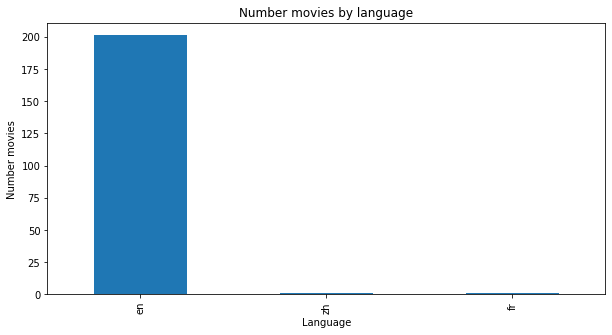

In [131]:
movies_oscars['original_language'].value_counts().nlargest(40).plot(kind= 'bar', figsize=(10,5))
plt.title('Number movies by language')
plt.ylabel('Number movies')
plt.xlabel('Language')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2499c310>,
      dtype=object)

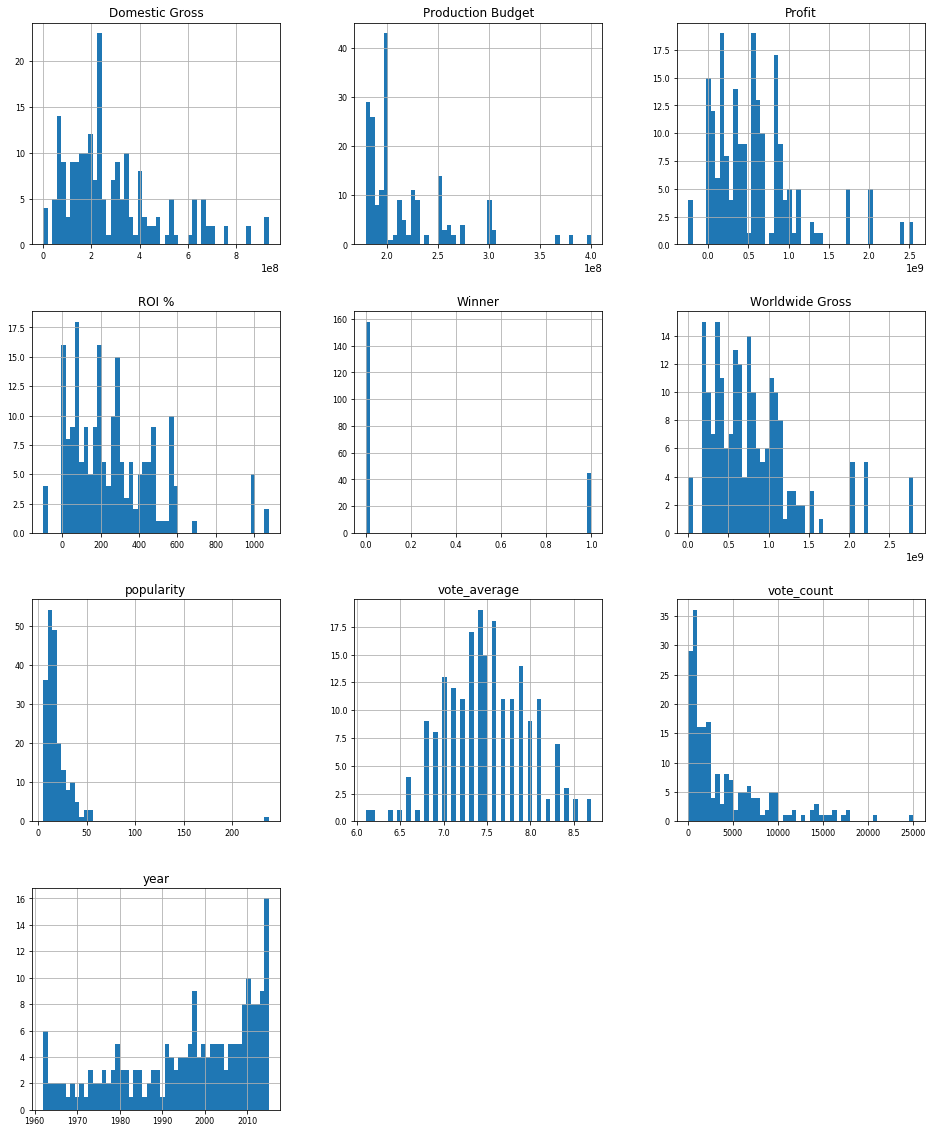

In [132]:
movies_oscars.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

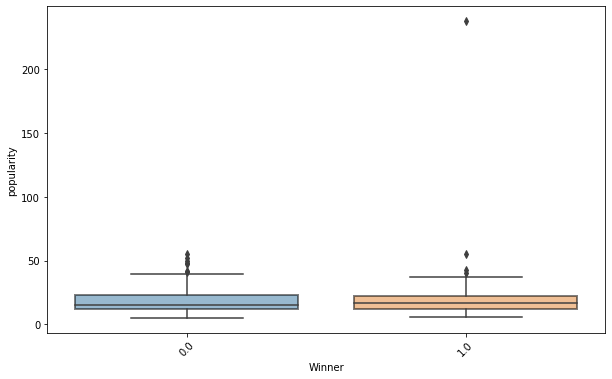

In [133]:
plt.figure(figsize = (10, 6))
ax = sb.boxplot(x='Winner', y='popularity', data=movies_oscars)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [134]:
movies_oscars[movies_oscars['popularity']>175]

,Year,Winner,title,title_year,popularity,vote_count,original_language,original_title,genre_ids,vote_average,release_date,year,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %
105,2000,1.0,gladiator,Gladiator 2000,237.606,11244,en,Gladiator,"[28, 12, 18]",8.1,2000-05-01,2000,195000000,65187603,197687603,2687603,1.378258


In [135]:
movies_oscars_no_gladiator = movies_oscars.drop(105)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

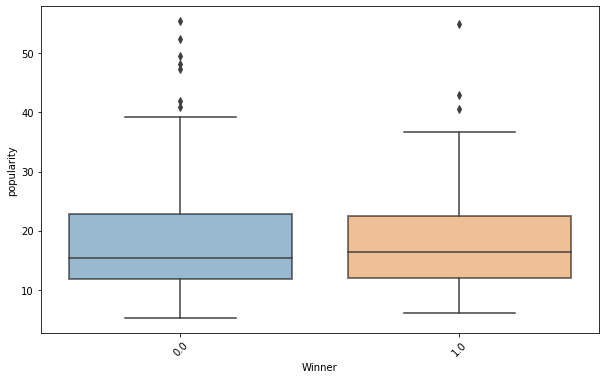

In [136]:
#without outlier 

plt.figure(figsize = (10, 6))
ax = sb.boxplot(x='Winner', y='popularity', data=movies_oscars_no_gladiator)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [137]:
# Finding the relations between the variables.
movies_oscars.corr()
#popular movies, with high vote counts and vote average are correlated with high ROI 

,Winner,popularity,vote_count,vote_average,year,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %
Winner,1.000000,0.128022,0.029815,0.228688,-0.272859,-0.034630,-0.016622,0.008960,0.012079,0.026280
popularity,0.128022,1.000000,0.573663,0.402416,0.173098,-0.031536,-0.005956,0.013461,0.016464,0.030124
vote_count,0.029815,0.573663,1.000000,0.559676,0.385178,-0.009393,0.097082,0.129025,0.133755,0.161772
vote_average,0.228688,0.402416,0.559676,1.000000,-0.032284,-0.035006,0.036757,0.047506,0.051839,0.084848
year,-0.272859,0.173098,0.385178,-0.032284,1.000000,0.034964,0.095457,0.043336,0.041793,0.032709
Production Budget,-0.034630,-0.031536,-0.009393,-0.035006,0.034964,1.000000,0.333048,0.407784,0.338151,0.089296
Domestic Gross,-0.016622,-0.005956,0.097082,0.036757,0.095457,0.333048,1.000000,0.912221,0.912851,0.861063
Worldwide Gross,0.008960,0.013461,0.129025,0.047506,0.043336,0.407784,0.912221,1.000000,0.997183,0.930401
Profit,0.012079,0.016464,0.133755,0.051839,0.041793,0.338151,0.912851,0.997183,1.000000,0.951611
ROI %,0.026280,0.030124,0.161772,0.084848,0.032709,0.089296,0.861063,0.930401,0.951611,1.000000


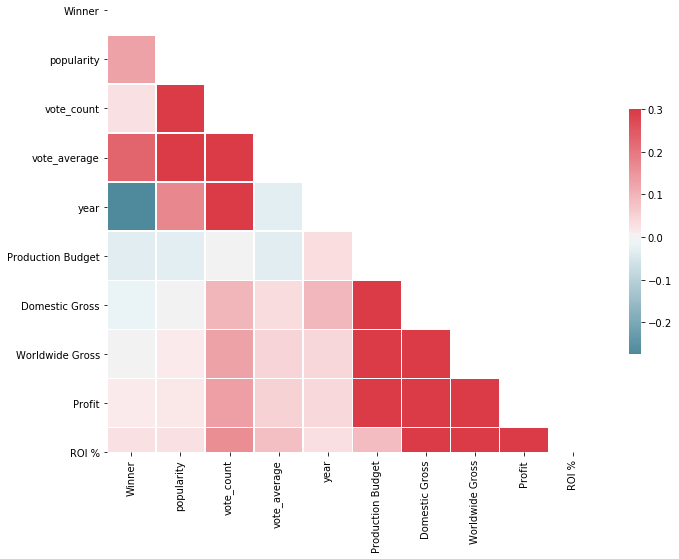

In [138]:
corr = movies_oscars.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

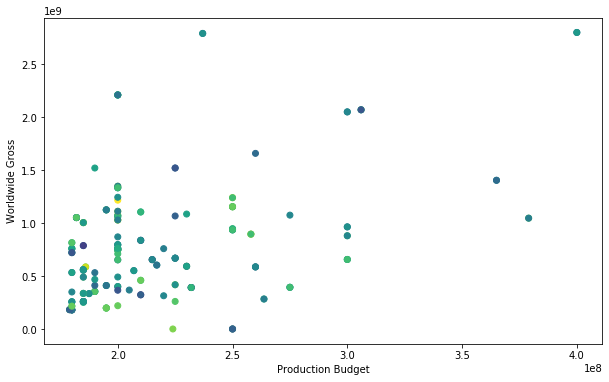

In [151]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(movies_oscars['Production Budget'], movies_oscars['Worldwide Gross'], c = movies_oscars['vote_average'])
ax.set_xlabel('Production Budget')
ax.set_ylabel('Worldwide Gross')
plt.show()

#LEGENDAAAAAA

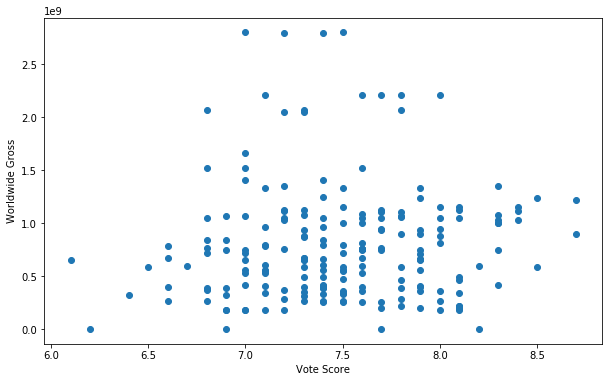

In [140]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(movies_oscars['vote_average'], movies_oscars['Worldwide Gross'])
ax.set_xlabel('Vote Score')
ax.set_ylabel('Worldwide Gross')
plt.show()

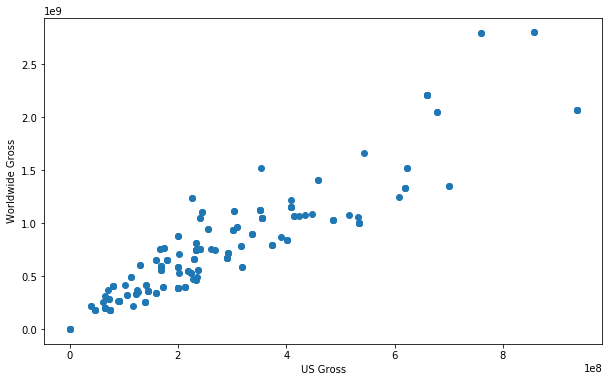

In [141]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(movies_oscars['Domestic Gross'], movies_oscars['Worldwide Gross'])
ax.set_xlabel('US Gross')
ax.set_ylabel('Worldwide Gross')
plt.show()

#very likely that if a movie performs well in the US will also perform well outside

In [142]:
# separate based on generations

#1962-1980 - Boomer
#1980-1998 - Millennials
#1998-2015 - Gen Z

movies_oscars.loc[(movies_oscars['year'] < 1980), 'Movie Generation'] = 'Boomer movie'
movies_oscars.loc[(movies_oscars['year'] >= 1980) & (movies_oscars['year'] < 1998), 'Movie Generation'] = 'Millennial movie'
movies_oscars.loc[(movies_oscars['year'] > 1998), 'Movie Generation'] = 'Gen Z movie'

movies_oscars_no_gladiator = movies_oscars.drop(105)

movies_oscars.head()

,Year,Winner,title,title_year,popularity,vote_count,original_language,original_title,genre_ids,vote_average,release_date,year,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %,Movie Generation
0,1962,1.0,lawrence of arabia,Lawrence of Arabia 1962,15.211,1652,en,Lawrence of Arabia,"[12, 18, 36, 10752]",8.0,1962-12-10,1962,200000000,659363944,2208208395,2008208395,1004.104198,Boomer movie
1,1962,0.0,the longest day,The Longest Day 1962,9.285,503,en,The Longest Day,"[18, 36, 10752]",7.6,1962-09-25,1962,180000000,241407328,758536735,578536735,321.409297,Boomer movie
2,1962,0.0,mutiny on the bounty,Mutiny on the Bounty 1962,8.371,144,en,Mutiny on the Bounty,"[12, 18, 36]",6.9,1962-11-08,1962,210000000,402111870,836519699,626519699,298.342714,Boomer movie
3,1962,0.0,to kill a mockingbird,To Kill a Mockingbird 1962,12.926,1499,en,To Kill a Mockingbird,"[80, 18]",8.0,1962-12-25,1962,250000000,408084349,1153284349,903284349,361.313740,Boomer movie
4,1963,0.0,cleopatra,Cleopatra 1963,14.356,329,en,Cleopatra,"[18, 36, 10749]",7.0,1963-06-12,1963,180000000,223808164,532508025,352508025,195.837792,Boomer movie


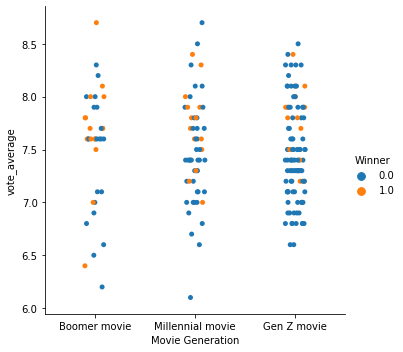

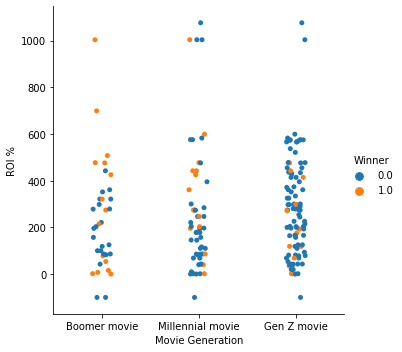

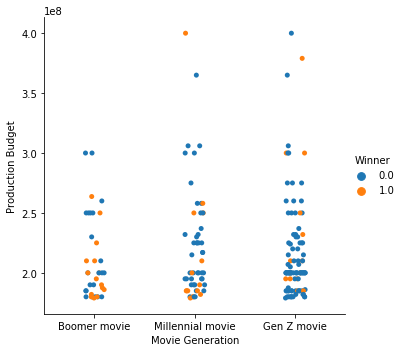

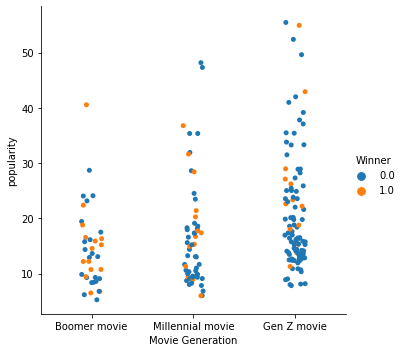

In [143]:
sb.catplot(x = 'Movie Generation', y = 'vote_average', hue = 'Winner', data = movies_oscars)
sb.catplot(x = 'Movie Generation', y = 'ROI %', hue = 'Winner', data = movies_oscars)
sb.catplot(x = 'Movie Generation', y = 'Production Budget', hue = 'Winner', data = movies_oscars)
sb.catplot(x = 'Movie Generation', y = 'popularity', hue = 'Winner', data = movies_oscars_no_gladiator)

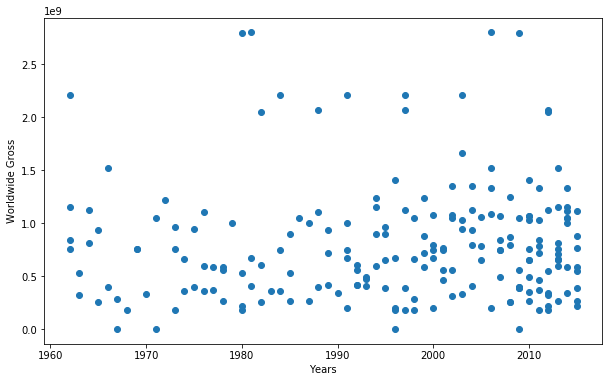

In [144]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(movies_oscars['year'], movies_oscars['Worldwide Gross'])
ax.set_xlabel('Years')
ax.set_ylabel('Worldwide Gross')
plt.show()

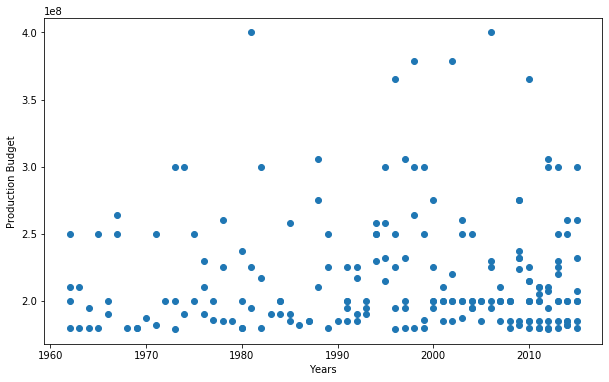

In [145]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(movies_oscars['year'], movies_oscars['Production Budget'])
ax.set_xlabel('Years')
ax.set_ylabel('Production Budget')
plt.show()

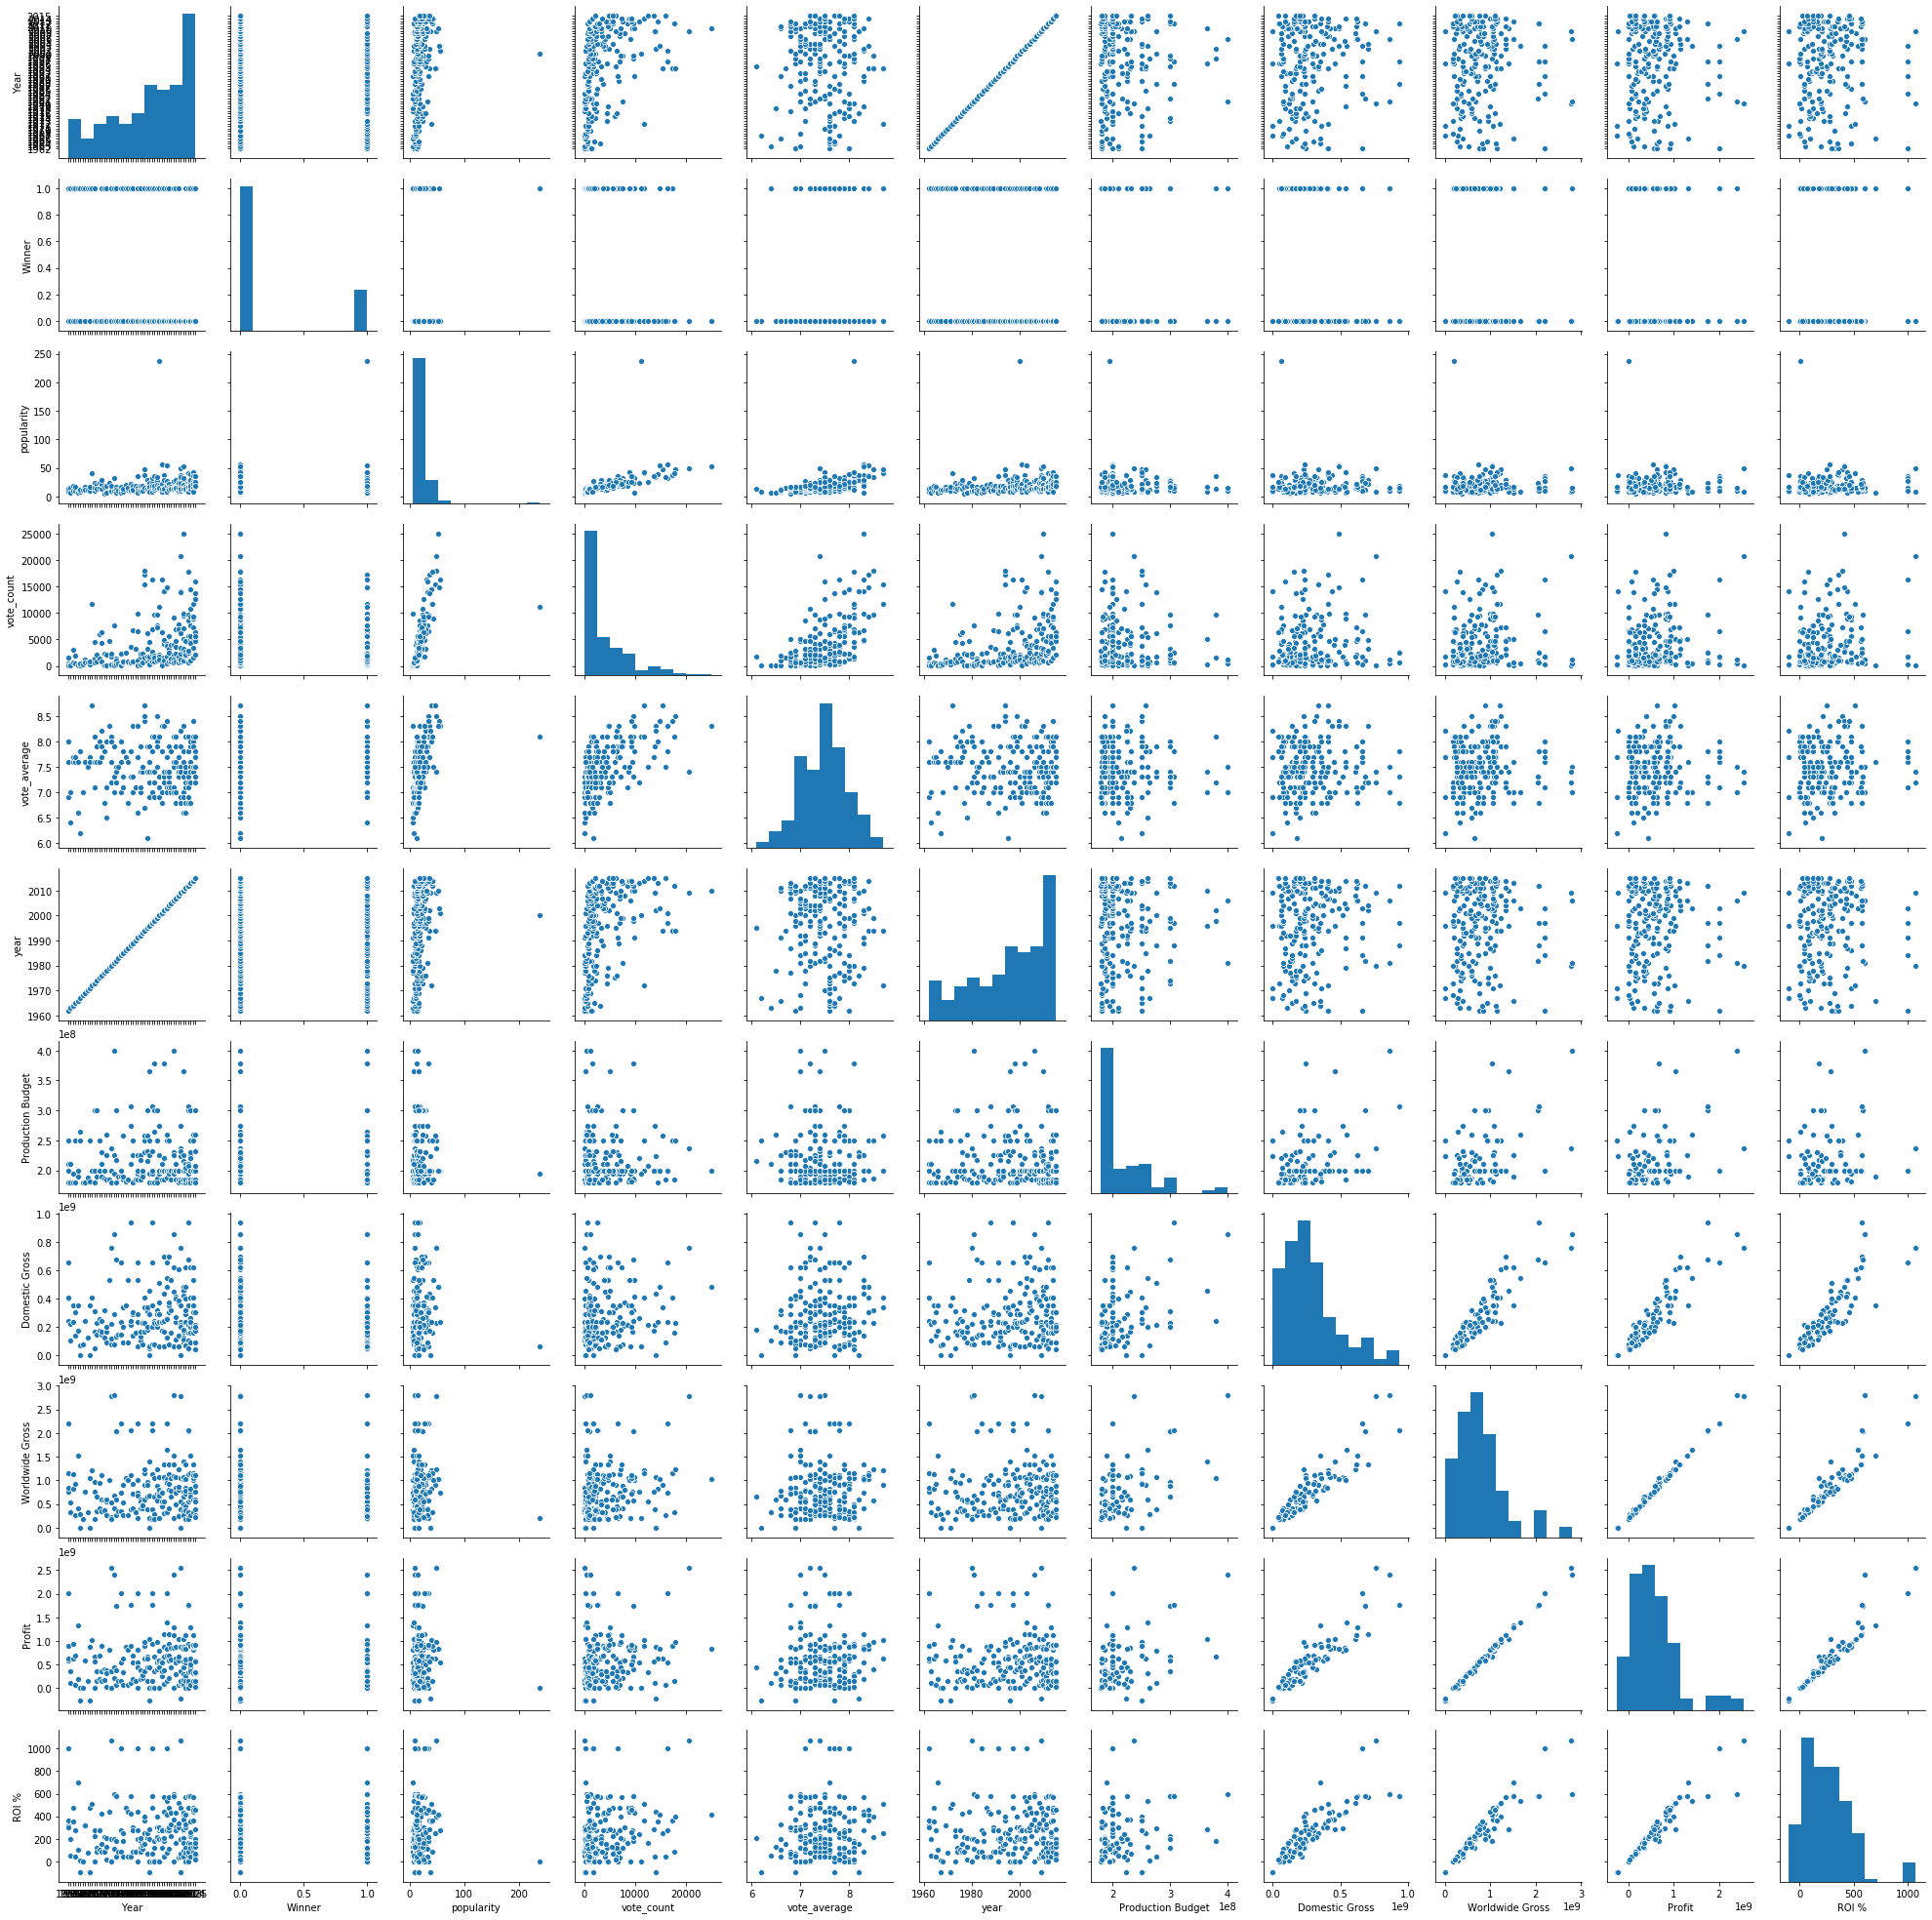

In [146]:
sb.pairplot(movies_oscars)

### Movies that have not been to the oscars

In [148]:
movies_no_oscars = df_finalissima[~df_finalissima['title'].isin(movies_oscars['title'])]
movies_no_oscars.sort_values(by=['Release Date'])

,Release Date,title,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %
id,,,,,,,
"5,344",1968,shalako,200000000,700059566,1346913161,1146913161,573.456580
"3,639",1970,the molly maguires,210000000,245439076,1104054072,894054072,425.740034
"5,038",1971,escape from the planet of the apes,210000000,402111870,836519699,626519699,298.342714
"5,243",1973,battle for the planet of the apes,205000000,70107728,367262558,162262558,79.152467
"5,398",1976,the blue bird,180000000,73864507,180047784,47784,0.026547
...,...,...,...,...,...,...,...
904,"Sep 9, 2011",contagion,306000000,936662225,2068223624,1762223624,575.890073
871,"Sep 9, 2015",maze runner: the scorch trials,195000000,352390543,1123794079,928794079,476.304656
"2,874","Sep 9, 2015",the perfect guy,190000000,353007020,1518722794,1328722794,699.327786


In [ ]:
movies_no_oscars = movies_no_oscars.replace(to_replace ="\d{4}", value = 'New_', regex = True) 

In [110]:
movies_no_oscars.mean(axis = 0)

Production Budget    2.180049e+08
Domestic Gross       2.809677e+08
Worldwide Gross      7.984843e+08
Profit               5.804794e+08
ROI %                2.613711e+02
dtype: float64

In [111]:
movies_no_oscars.corr()

,Production Budget,Domestic Gross,Worldwide Gross,Profit,ROI %
Production Budget,1.000000,0.344108,0.441588,0.373020,0.119584
Domestic Gross,0.344108,1.000000,0.907874,0.910065,0.865863
Worldwide Gross,0.441588,0.907874,1.000000,0.997181,0.928838
Profit,0.373020,0.910065,0.997181,1.000000,0.950521
ROI %,0.119584,0.865863,0.928838,0.950521,1.000000


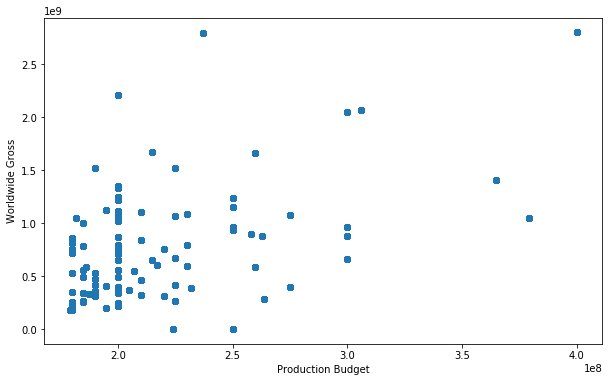

In [112]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(movies_no_oscars['Production Budget'], movies_no_oscars['Worldwide Gross'])
ax.set_xlabel('Production Budget')
ax.set_ylabel('Worldwide Gross')
plt.show()

In [ ]:
TMDB_data['year'] = pd.DatetimeIndex(TMDB_data['release_date']).year
TMDB_data.head()

### Kaagle database

In [163]:
kaagle = pd.read_csv('movies_metadata.csv', low_memory=False)
kaagle.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [164]:
kaagle['original_title'] = kaagle['original_title'].apply(lambda x: x.lower())

In [165]:
kaagle[kaagle['original_title'] == 'spotlight']


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
33041,False,NaN,20000000,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",http://www.spotlightthefilm.com,314365,tt1895587,en,spotlight,The true story of how The Boston Globe uncover...,...,2015-11-06,88346473.0,128.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Break the story. Break the silence.,Spotlight,False,7.8,2751.0


In [166]:
kaagle[kaagle['original_title'] == 'lawrence of arabia']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
1162,False,NaN,15000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",NaN,947,tt0056172,en,lawrence of arabia,An epic about British officer T.E. Lawrence's ...,...,1962-12-10,69995385.0,216.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,NaN,Lawrence of Arabia,False,7.8,870.0


In [167]:
kaagle.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [170]:
del kaagle['adult']
del kaagle['belongs_to_collection']
del kaagle['genres']
del kaagle['homepage']
del kaagle['id']
del kaagle['imdb_id']
del kaagle['original_language']
del kaagle['overview']
del kaagle['popularity']
del kaagle['poster_path']
del kaagle['status']
del kaagle['tagline']
del kaagle['title']
del kaagle['video']
del kaagle['vote_average']
del kaagle['vote_count']

In [172]:
del kaagle['spoken_languages']

In [175]:
kaagle = kaagle.rename({'original_title': 'title'}, axis=1)
kaagle.head()

,budget,title,production_companies,production_countries,release_date,revenue,runtime
0,30000000,toy story,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0
1,65000000,jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0
2,0,grumpier old men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0
3,16000000,waiting to exhale,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0
4,0,father of the bride part ii,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0


### Merge all datasets

In [178]:
movies_oscars_kaagle = pd.merge(kaagle, movies_oscars, on='title')

In [179]:
del movies_oscars_kaagle['Production Budget']
movies_oscars_kaagle

,budget,title,production_companies,production_countries,release_date_x,revenue,runtime,Year,Winner,title_year,...,original_title,genre_ids,vote_average,release_date_y,year,Domestic Gross,Worldwide Gross,Profit,ROI %,Movie Generation
0,16500000,sense and sensibility,"[{'name': 'Columbia Pictures Corporation', 'id...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-12-13,135000000.0,136.0,1995,0.0,Sense and Sensibility 1995,...,Sense and Sensibility,"[18, 10749]",7.4,1995-12-13,1995,200120000,391081192,159081192,68.569479,Millennial movie
1,0,sense and sensibility,"[{'name': 'BBC Worldwide', 'id': 3164}, {'name...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2008-01-01,0.0,174.0,1995,0.0,Sense and Sensibility 1995,...,Sense and Sensibility,"[18, 10749]",7.4,1995-12-13,1995,200120000,391081192,159081192,68.569479,Millennial movie
2,0,sense and sensibility,[{'name': 'British Broadcasting Corporation (B...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1981-02-01,0.0,174.0,1995,0.0,Sense and Sensibility 1995,...,Sense and Sensibility,"[18, 10749]",7.4,1995-12-13,1995,200120000,391081192,159081192,68.569479,Millennial movie
3,0,sense and sensibility,[],[],1971-01-01,0.0,178.0,1995,0.0,Sense and Sensibility 1995,...,Sense and Sensibility,"[18, 10749]",7.4,1995-12-13,1995,200120000,391081192,159081192,68.569479,Millennial movie
4,30000000,babe,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...",1995-07-18,254134910.0,89.0,1995,0.0,Babe 1995,...,Babe,"[35, 18, 14, 10751]",6.1,1995-07-18,1995,179020854,654213485,439213485,204.285342,Millennial movie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,6000000,room,"[{'name': 'Téléfilm Canada', 'id': 806}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2015-10-16,35401758.0,117.0,2015,0.0,Room 2015,...,Room,"[18, 53]",8.1,2015-10-16,2015,40479370,215098356,35098356,19.499087,Gen Z movie
236,0,room,[],[],2005-04-01,0.0,0.0,2015,0.0,Room 2015,...,Room,"[18, 53]",8.1,2015-10-16,2015,40479370,215098356,35098356,19.499087,Gen Z movie
237,20000000,spotlight,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2015-11-06,88346473.0,128.0,2015,1.0,Spotlight 2015,...,Spotlight,"[18, 53, 36]",7.8,2015-11-06,2015,200120000,391081192,159081192,68.569479,Gen Z movie
238,40000000,bridge of spies,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'IN', 'name': 'India'}, {'iso_...",2015-10-15,165478348.0,141.0,2015,0.0,Bridge of Spies 2015,...,Bridge of Spies,"[18, 53]",7.2,2015-10-15,2015,304360277,1110526981,910526981,455.263490,Gen Z movie


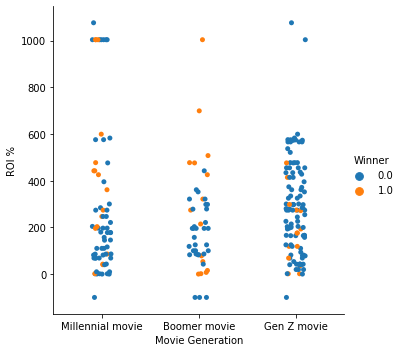

In [187]:

sb.catplot(x = 'Movie Generation', y = 'ROI %', hue = 'Winner', data = movies_oscars_kaagle)


In [194]:
movies_oscars_kaagle_budget = movies_oscars_kaagle.groupby(['Winner'])['budget'].describe().reset_index()
movies_oscars_kaagle_budget

,Winner,count,unique,top,freq
0,0.0,193,79,0,35
1,1.0,47,36,15000000,5


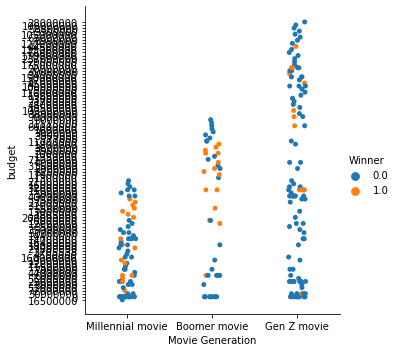

In [198]:
sb.catplot(x = 'Movie Generation', y = 'budget', hue = 'Winner', data = movies_oscars_kaagle)
ax.set_yticks(np.arange(10000000, 40000000, 10000000), minor=False)
plt.show()